In [1]:
import os
import sys
from itertools import product
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import mlflow
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
from optuna.trial import create_trial
from optuna.distributions import CategoricalDistribution, IntUniformDistribution, LogUniformDistribution

sys.path.append(os.path.join(os.getcwd(), "../")) 
from results import log_best_model

In [2]:
# Setting up the tracking_uri and the experiment name
mlflow.set_tracking_uri("../../outputs/experiments/mlruns")
mlflow.set_experiment(experiment_name='mapintel-experiment-v1')

In [3]:
# Querying the runs
df_results= mlflow.search_runs()
df_results.shape

Traceback (most recent call last):
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 699, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 529, in _get_run_info_from_dir
    meta = read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 170, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '../../outputs/experiments/mlruns/1/.trash/meta.yaml' does not exist.


(101, 102)

In [4]:
# Isolate best run
best_run = df_results.loc[df_results['tags.mlflow.runName'] == 'best-model']
df_results = df_results.loc[~(df_results['tags.mlflow.runName'] == 'best-model')]

In [5]:
k_range = [10, 20, 40, 80, 160]
# Compute umap_avgknn_acc_test_mean (if needed)
if 'metrics.umap_avgknn_acc_test_mean' not in df_results.columns:
    df_results['metrics.umap_avgknn_acc_test_mean'] = \
    np.mean([df_results[f'metrics.umap_{k}nn_acc_test_mean'] for k in k_range], axis=0)
    
# Compute umap_avgknn_acc_test_std (if needed)
if 'metrics.umap_avgknn_acc_test_std' not in df_results.columns:
    df_results['metrics.umap_avgknn_acc_test_std'] = \
    np.mean([df_results[f'metrics.umap_{k}nn_acc_test_std'] for k in k_range], axis=0)

# Compute minmax_avg
df_results['metrics.minmax_avg'] = np.mean(MinMaxScaler().fit_transform(df_results[['metrics.nmi_test_mean', 'metrics.topic_coherence_c_v_mean', 'metrics.umap_avgknn_acc_test_mean']]), axis=1)

# Compute total_infer_time
df_results['metrics.timer_total_infer_mean'] = np.sum(df_results[['metrics.timer_emb_model_infer_mean', 'metrics.timer_top_model_infer_mean']], axis=1)

In [6]:
# Relevant columns
relv_cols = [
    'run_id', 'experiment_id', 'start_time', 'artifact_uri', 
     # metrics
     'metrics.minmax_avg', 'metrics.nmi_test_mean', 
     'metrics.topic_coherence_c_v_mean', 'metrics.umap_avgknn_acc_test_mean', 
     'metrics.umap_avgknn_acc_test_std', 'metrics.topic_diversity_mean', 
     'metrics.timer_total_infer_mean',
     # params
     'params.n_neighbors', 'params.max_iter', 'params.embedding_model', 
     'params.n_components', 'params.topic_model', 'params.metric', 'params.dm', 
     'params.cv-folds', 'params.learning_decay', 'params.max_doc_update_iter', 
     'params.hidden_sizes', 'params.dropout', 'params.activation', 
     'params.inference_type', 'params.num_epochs', 'params.model_type', 'params.lr', 
     'params.cluster_selection_epsilon', 'params.min_topic_size', 
     'params.min_cluster_size', 'params.cluster_selection_method'
]

In [7]:
# Display top 10 results
df_results = df_results.sort_values(by=['metrics.nmi_test_mean', 'metrics.topic_coherence_c_v_mean', 'metrics.umap_avgknn_acc_test_mean'], ascending=False)
df_results[relv_cols].head(10).T

,45,89,76,9,10,81,71,31,14,43
run_id,6c70ea4b968f4267a1468252c0efa3ee,410ddfd0f9e84f11b90fcb30bc1fd8e7,6dcbc20f72b24fa59f63129e9d13cd61,71d158566a5d43d1a6a44111e14cf292,6f188aeeb93748f88e721a65a83d118e,f11cc7d580c54d33a83b714c0729e2c2,20d97a441b054e12ba65b4336d140d67,d9c33d95be79432ea5aeaa0ae222489c,b2bc5c50dcc341928547b1a76a63c9ce,f984efb617d248cba802c38904d93968
experiment_id,1,1,1,1,1,1,1,1,1,1
start_time,2021-12-03 03:10:29.534000+00:00,2021-12-01 06:20:11.551000+00:00,2021-12-01 19:35:16.729000+00:00,2021-12-04 20:06:28.494000+00:00,2021-12-04 19:47:11.228000+00:00,2021-12-01 17:00:03.714000+00:00,2021-12-01 22:30:57.762000+00:00,2021-12-03 12:43:41.152000+00:00,2021-12-04 14:49:30.565000+00:00,2021-12-03 03:47:18.236000+00:00
artifact_uri,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...
metrics.minmax_avg,0.870493,0.88339,0.942027,0.912004,0.927695,0.588635,0.703845,0.677709,0.52629,0.513242
metrics.nmi_test_mean,0.403374,0.374233,0.362758,0.357663,0.344467,0.330134,0.328578,0.301361,0.287471,0.272917
metrics.topic_coherence_c_v_mean,0.683588,0.752861,0.758729,0.761128,0.75985,0.367578,0.576081,0.528268,0.542882,0.566994
metrics.umap_avgknn_acc_test_mean,0.306803,0.295559,0.358676,0.331575,0.358676,0.306196,0.277473,0.306803,0.158775,0.141164
metrics.umap_avgknn_acc_test_std,0.043483,0.048093,0.012298,0.023355,0.012298,0.037638,0.04136,0.043483,0.011309,0.007737
metrics.topic_diversity_mean,0.87441,0.87975,0.879028,0.892,0.881905,0.98,0.935,0.868,0.824,0.81


In [8]:
print("The run with highest minmax_avg has index", df_results['metrics.minmax_avg'].argmax())

The run with highest minmax_avg has index 2


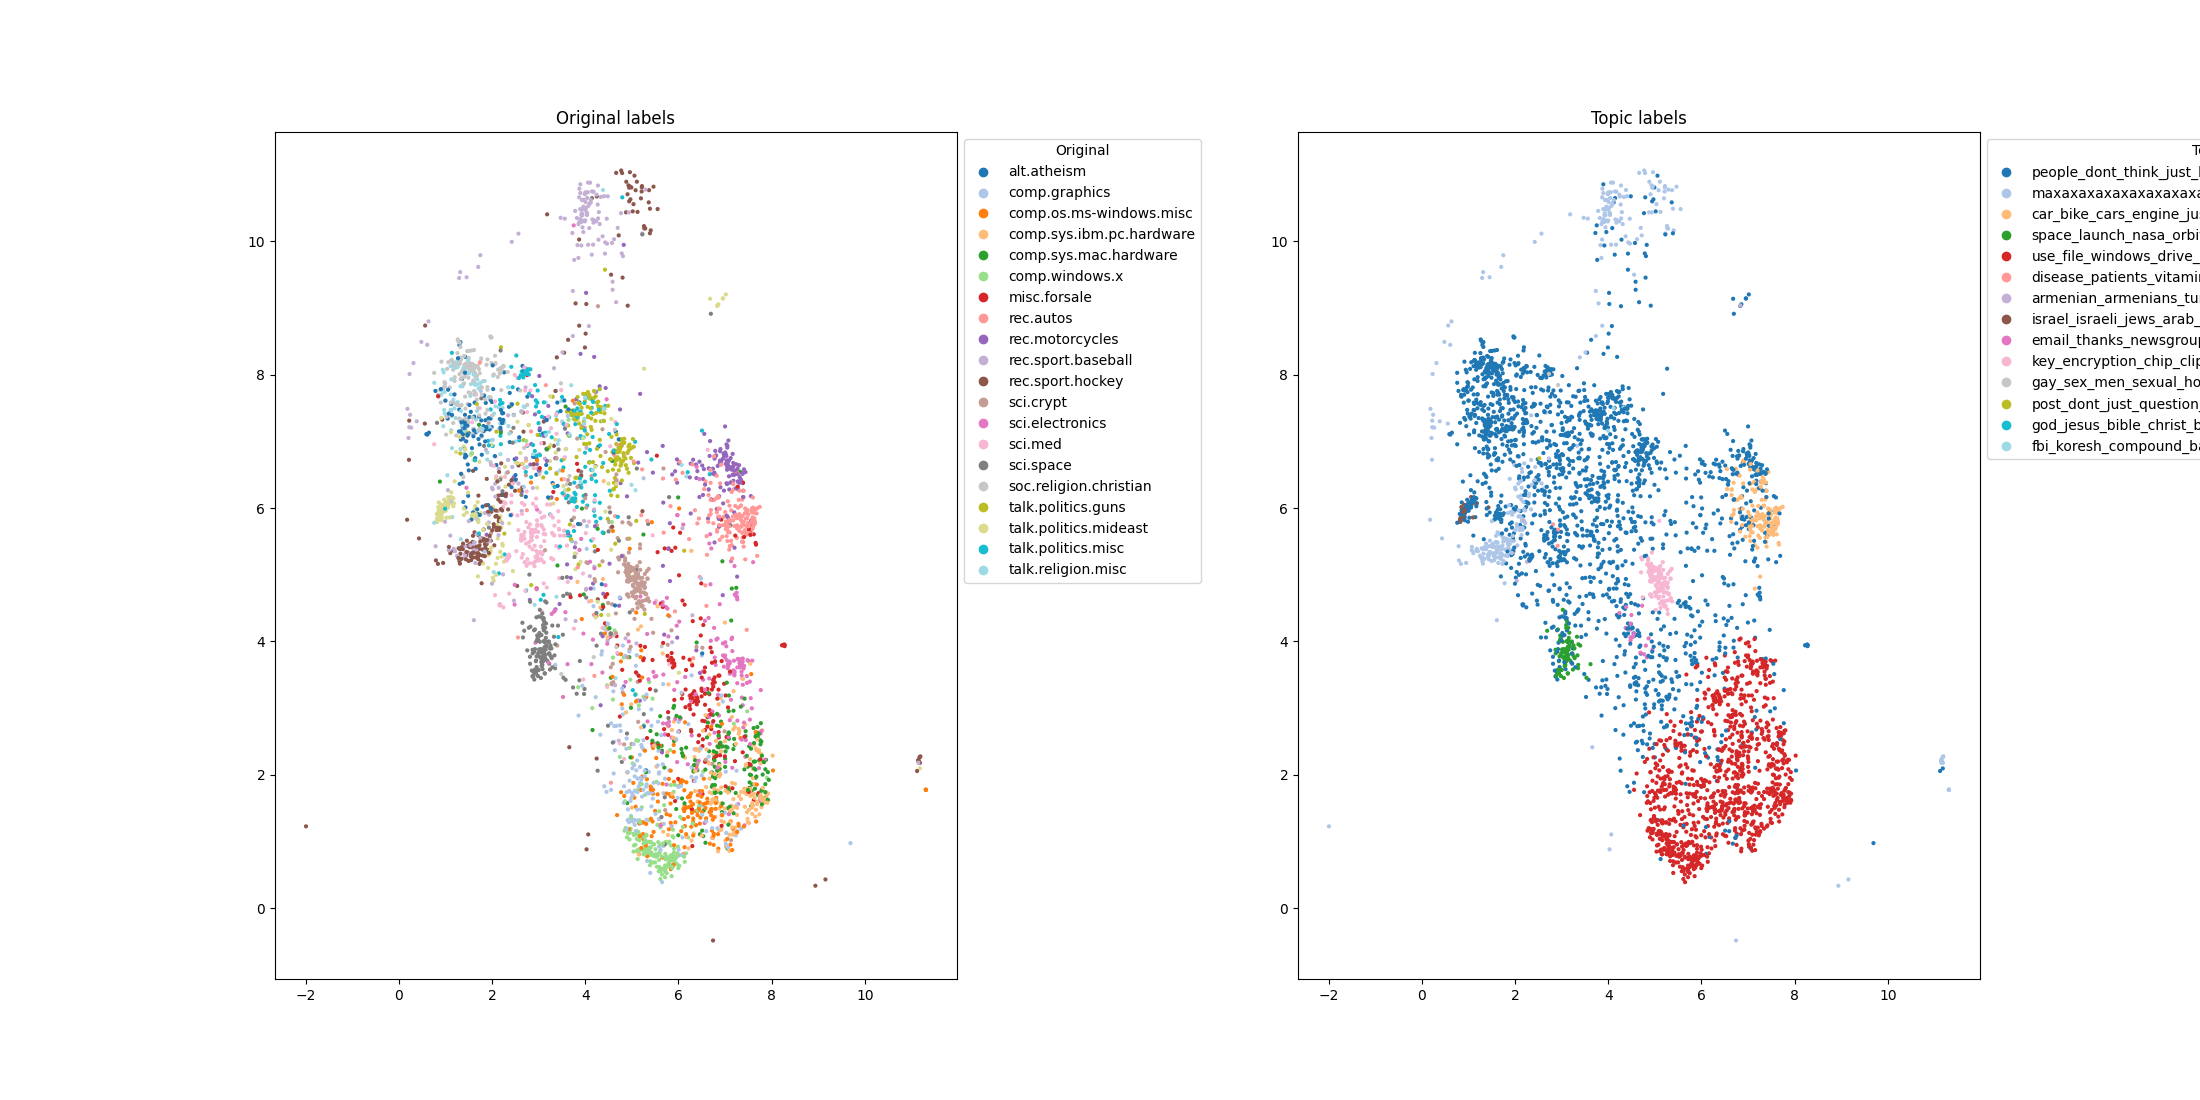

In [9]:
# Visualize UMAP test plot from top 1 run
Image(os.path.join(df_results.iloc[0]['artifact_uri'], 'umap_test_plot.png'))

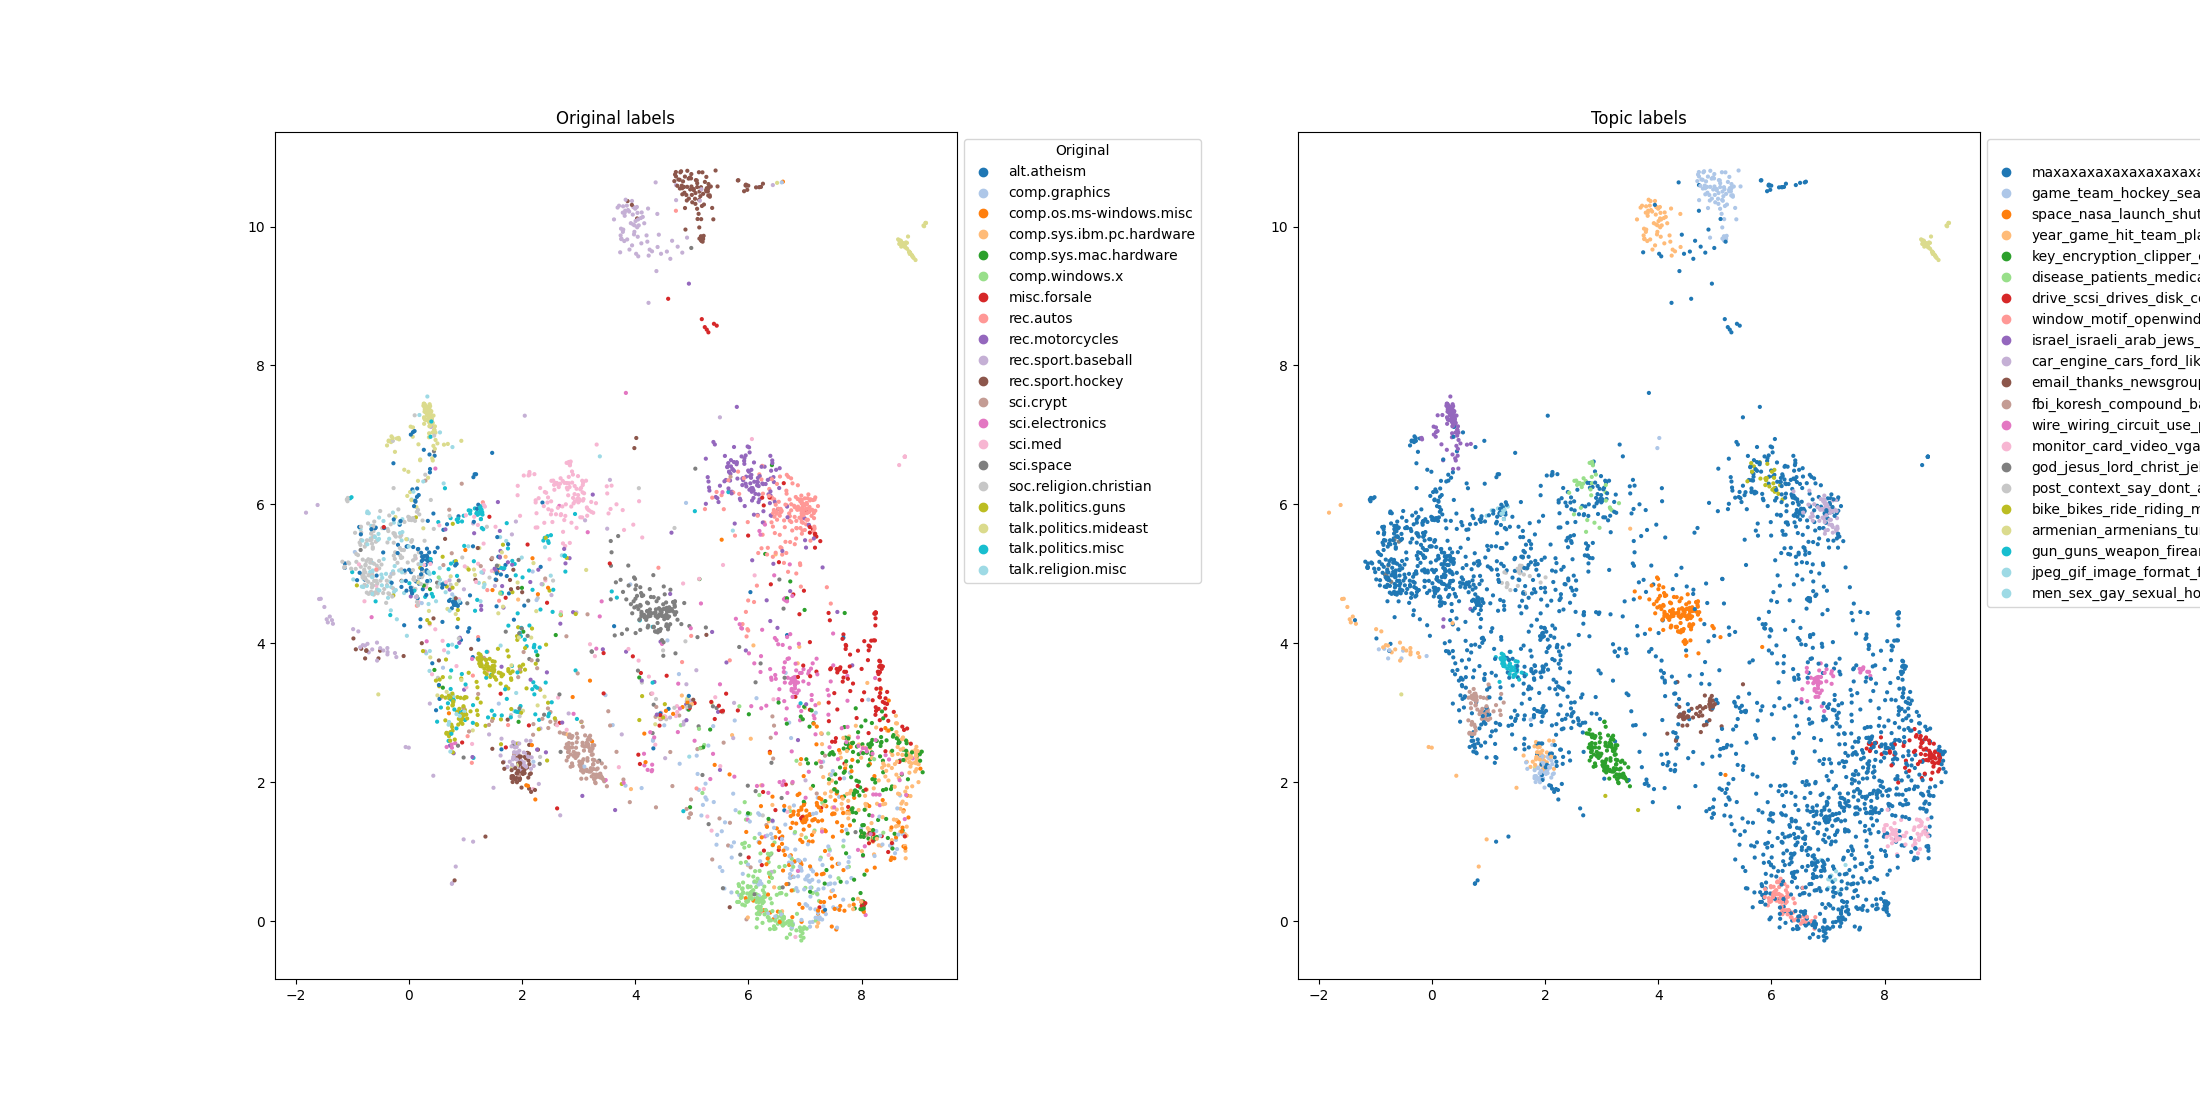

In [10]:
# Visualize UMAP test plot from highest minmax_avg
top_result = df_results.iloc[df_results['metrics.minmax_avg'].argmax()]
Image(os.path.join(top_result['artifact_uri'], 'umap_test_plot.png'))

In [11]:
# Get best-model trial
best_run = mlflow.search_runs(filter_string="tags.mlflow.runName = 'best-model'")

if best_run.shape[0] == 0:
    # Re-evaluate the model with the best hyperparameters on a train/test split
    params = top_result[top_result.index.str.contains('params.')].dropna().sort_index().to_dict()
    dtypes = [float, str, int, str, str, int, int, int, int, str]
    params = {k.split('.')[1]: t(v) for (k, v), t in zip(params.items(), dtypes)}
    distributions = [
        LogUniformDistribution(0.01, 1.0),
        CategoricalDistribution(['eom', 'leaf']),
        CategoricalDistribution([5]),
        CategoricalDistribution(['doc2vec', 'sentence-transformers/msmarco-distilbert-base-v4']),
        CategoricalDistribution(['cosine', 'euclidean']),
        IntUniformDistribution(30, 150),
        IntUniformDistribution(10, 60),
        CategoricalDistribution([2, 5, 10, 25, 50]),
        IntUniformDistribution(10,50),
        CategoricalDistribution(['BERTopic', 'CTM', 'LDA'])
    ]
    best_trial = create_trial(
        value = top_result['metrics.minmax_avg'],
        params = params,
        distributions = dict(zip(params.keys(), distributions))
    )
    
    # Train the best model to get additional outputs
    log_best_model(best_trial)
else:
    # Print best_run
    from pprint import pprint
    pprint(best_run.to_dict())

Traceback (most recent call last):
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 699, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 529, in _get_run_info_from_dir
    meta = read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 170, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '../../outputs/experiments/mlruns/1/.trash/meta.yaml' does not exist.


{'artifact_uri': {0: '/home/dsilva/projects/mapintel/experiments/../outputs/experiments/mlruns/1/7ddc83f972144d1f848a8fed5de39feb/artifacts'},
 'end_time': {0: Timestamp('2022-02-03 20:30:47.853000+0000', tz='UTC')},
 'experiment_id': {0: '1'},
 'metrics.inverted_rbo': {0: 0.9866241483920408},
 'metrics.nmi_filtered_test': {0: 0.7130451161540198},
 'metrics.nmi_filtered_train': {0: 0.681106925164886},
 'metrics.nmi_test': {0: 0.40412901667658196},
 'metrics.nmi_train': {0: 0.4154609221347837},
 'metrics.ntopics': {0: 21.0},
 'metrics.perc_outliers_test': {0: 0.5666206896551724},
 'metrics.perc_outliers_train': {0: 0.514},
 'metrics.timer_emb_model_infer': {0: 22.529397612997855},
 'metrics.timer_emb_model_train': {0: 100.07182587499847},
 'metrics.timer_top_model_infer': {0: 23.182009579002624},
 'metrics.timer_top_model_train': {0: 35.963751595998474},
 'metrics.topic_coherence_c_v': {0: 0.7671349827332538},
 'metrics.topic_diversity': {0: 0.8761904761904762},
 'metrics.umap_10nn_acc_

## UMAP plot with labels of best solution

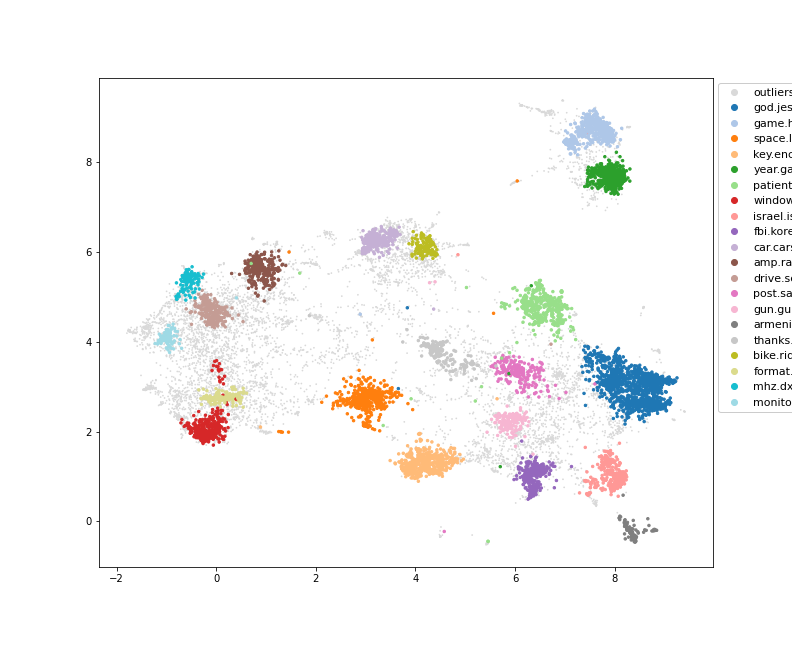

In [12]:
# Visualize UMAP train plot from best-model trial 
Image(os.path.join(best_run['artifact_uri'][0], 'top_umap_train_plot.png'))

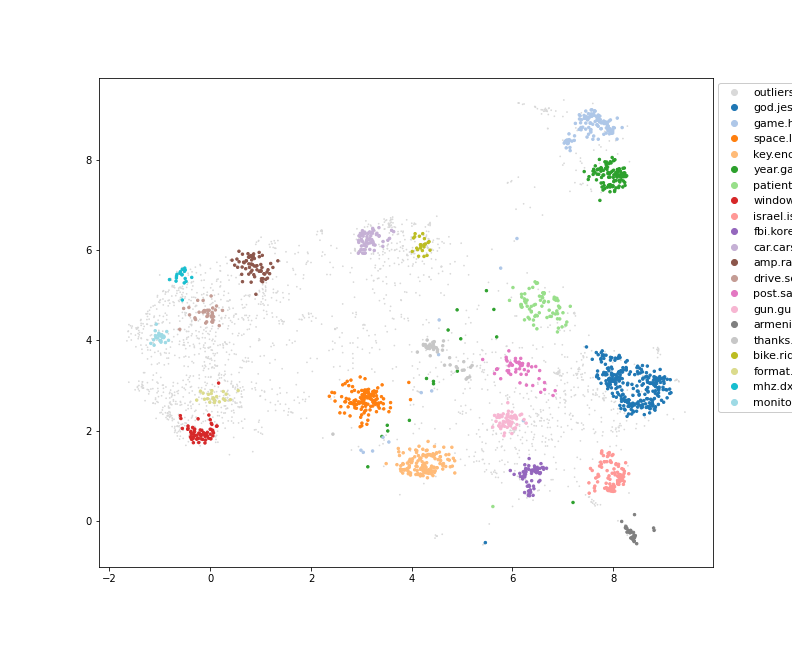

In [13]:
# Visualize UMAP test plot from best-model trial 
Image(os.path.join(best_run['artifact_uri'][0], 'top_umap_test_plot.png'))

## KNN Classifier Accuracy plot

<ipython-input-14-3fdf4dfdeeae>:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(data.loc[g].T, c=c, marker='x', label=' + '.join(g))


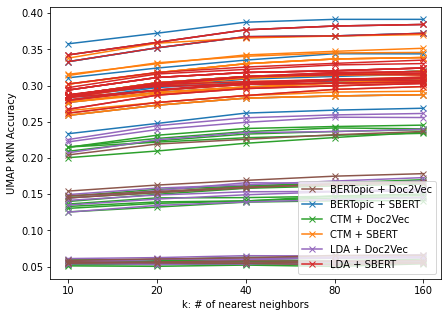

In [14]:
data = df_results[['params.topic_model', 'params.embedding_model'] + [f'metrics.umap_{k}nn_acc_test_mean' for k in k_range]]
data['params.embedding_model'] = data['params.embedding_model'].map({'doc2vec': 'Doc2Vec', 'sentence-transformers/msmarco-distilbert-base-v4': 'SBERT'})
data.set_index(['params.topic_model', 'params.embedding_model'], drop=True, inplace=True)
groups = data.index.unique()
colors = plt.get_cmap('tab10').colors

fig, ax = plt.subplots(figsize=(7,5))
for g, c in zip(groups, colors):
    ax.plot(data.loc[g].T, c=c, marker='x', label=' + '.join(g))

handles, labels = ax.get_legend_handles_labels()
labels, handles_ix = np.unique(labels, return_index=True)
ax.legend(np.array(handles)[handles_ix], labels, loc='lower right')
plt.xticks(range(5), k_range)
ax.set_xlabel('k: # of nearest neighbors')
ax.set_ylabel('UMAP kNN Accuracy')

fig.show()

## Export results

In [18]:
# Building the results
exp_cols = [
    'params.topic_model', 
    'params.embedding_model', 
    'metrics.minmax_avg',
    'metrics.nmi_test_mean', 
    'metrics.nmi_test_std',
    'metrics.topic_coherence_c_v_mean', 
    'metrics.topic_coherence_c_v_std', 
    'metrics.umap_avgknn_acc_test_mean',
    'metrics.umap_avgknn_acc_test_std'
]
results = df_results[exp_cols].sort_values(by='metrics.minmax_avg', ascending=False).rename({
    'params.topic_model': 'Topic Model', 
    'params.embedding_model': 'Embedding Model',
    'metrics.nmi_test_mean': 'NMI',
    'metrics.nmi_test_std': 'NMI std',
    'metrics.topic_coherence_c_v_mean': 'Topic Coherence $C_v$',
    'metrics.topic_coherence_c_v_std': 'Topic Coherence $C_v$ std',
    'metrics.umap_avgknn_acc_test_mean': '$k$NN Classifier Accuracy',
    'metrics.umap_avgknn_acc_test_std': '$k$NN Classifier Accuracy std',
    'metrics.minmax_avg': 'MinMax Average'
}, axis=1).round(3)
results['Embedding Model'] = results['Embedding Model'].map({'doc2vec': 'Doc2Vec', 'sentence-transformers/msmarco-distilbert-base-v4': 'SBERT'})
results.sort_values(by='MinMax Average', ascending=False)

,Topic Model,Embedding Model,MinMax Average,NMI,NMI std,Topic Coherence $C_v$,Topic Coherence $C_v$ std,$k$NN Classifier Accuracy,$k$NN Classifier Accuracy std
76,BERTopic,SBERT,0.942,0.363,0.033,0.759,0.008,0.359,0.012
10,BERTopic,SBERT,0.928,0.344,0.040,0.760,0.028,0.359,0.012
9,BERTopic,SBERT,0.912,0.358,0.025,0.761,0.013,0.332,0.023
89,BERTopic,SBERT,0.883,0.374,0.026,0.753,0.013,0.296,0.048
45,BERTopic,SBERT,0.870,0.403,0.018,0.684,0.034,0.307,0.043
...,...,...,...,...,...,...,...,...,...
50,BERTopic,Doc2Vec,0.122,0.014,0.010,0.427,0.038,0.062,0.003
37,BERTopic,Doc2Vec,0.094,0.000,0.000,0.416,0.018,0.055,0.003
54,BERTopic,Doc2Vec,0.078,0.007,0.006,0.382,0.011,0.055,0.002
83,CTM,Doc2Vec,0.052,0.029,0.003,0.310,0.030,0.062,0.003


In [19]:
# Get Top Results
top_res = []
for pair in product(results['Topic Model'].unique(), results['Embedding Model'].unique()):
    top_res.append(results.loc[(results['Topic Model'] == pair[0]) & (results['Embedding Model'] == pair[1])].\
        sort_values(by='MinMax Average', ascending=False).iloc[0])
top_res = pd.concat(top_res, axis=1).T.reset_index(drop=True)
top_res

,Topic Model,Embedding Model,MinMax Average,NMI,NMI std,Topic Coherence $C_v$,Topic Coherence $C_v$ std,$k$NN Classifier Accuracy,$k$NN Classifier Accuracy std
0,BERTopic,SBERT,0.942,0.363,0.033,0.759,0.008,0.359,0.012
1,BERTopic,Doc2Vec,0.499,0.105,0.01,0.721,0.024,0.157,0.013
2,LDA,SBERT,0.71,0.261,0.034,0.531,0.029,0.369,0.051
3,LDA,Doc2Vec,0.576,0.248,0.028,0.529,0.029,0.249,0.014
4,CTM,SBERT,0.704,0.329,0.017,0.576,0.02,0.277,0.041
5,CTM,Doc2Vec,0.558,0.23,0.017,0.546,0.016,0.235,0.029
